#CLIP zeroshot

##Preparations

In [87]:
# === Standard Library Imports ===
import os                          # Interact with the operating system (e.g., file paths)
import random                      # Random number generation and shuffling


# === Third-Party Library Imports ===

# Image processing
from PIL import Image              # For loading and manipulating images

# Data science & computation
import numpy as np                # Numerical operations, especially arrays
import pandas as pd               # Data handling and manipulation (e.g., DataFrames)
import seaborn as sns

# Machine learning and deep learning
import torch                      # Core PyTorch library for tensor operations
from torch.utils.data import DataLoader, Dataset  # PyTorch utilities for datasets and batching

# Visualization
import matplotlib.pyplot as plt   # For creating plots and visualizations

# Transformers and embeddings
from transformers import CLIPModel, CLIPProcessor  # Hugging Face's CLIP model and its processor

# Dimensionality reduction and similarity metrics
from sklearn.metrics.pairwise import cosine_similarity  # To compute similarity between embeddings
from umap import UMAP                     # Dimensionality reduction for visualization


In [88]:
import hashlib

def fingerprint_model(model):
    weights = next(iter(model.state_dict().values()))
    return hashlib.sha256(weights.cpu().numpy().tobytes()).hexdigest()[:10]

In [89]:
# === Load CLIP Model & Processor ===

# Load the pretrained CLIP model from Hugging Face
# This model maps both images and texts into the same embedding space
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# The processor is responsible for preprocessing inputs (resizing, tokenizing, etc.)
# It prepares image and text inputs to match what the model expects
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


# === Define Dataset Path ===

# Construct the absolute path to the dataset folder (e.g., "../../Dataset_Circuitboard")
# This assumes the script is two levels down from the dataset root
base_path = os.path.abspath(os.path.join("..", "..", "Dataset_Circuitboard_labeld/train"))


# === Initialize a Dictionary to Hold Image Paths ===

# Dictionary to store image file paths, categorized by condition
reference_image_paths = {
    "good": [],  # Will store paths to healthy circuit board images
}


# === Loop Through Each Condition Folder ===

# Iterate over both 'Healthy' and 'Faulty' categories
for condition in reference_image_paths.keys():
    # Construct the path to the specific condition folder (e.g., "../../Dataset_Circuitboard/Healthy")
    folder_path = os.path.join(base_path, condition.capitalize())

    # Print the folder being accessed for clarity/debugging
    print(folder_path)

    # Check if the folder exists — useful for catching misnamed/missing directories
    if not os.path.exists(folder_path):
        print(f"⚠️ Folder not found: {folder_path}")
        continue  # Skip to the next condition if the folder doesn't exist

    # List all files in the folder and filter image files based on extensions
    for file_name in os.listdir(folder_path):
        # Accept common image formats
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Build the full path to the image file
            full_path = os.path.join(folder_path, file_name)

            # Append the image path to the corresponding list in the dictionary
            reference_image_paths[condition].append(full_path)


# === Output the Collected Image Paths ===

# Print the dictionary that now contains categorized image file paths
print(reference_image_paths)


d:\Cursor projects\Assignment2\Dataset_Circuitboard_labeld\train\Good
{'good': ['d:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200351.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200352.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200354.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200356.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200357.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200358.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200359.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200400.jpg', 'd:\\Cursor projects\\Assignment2\\Dataset_Circuitboard_labeld\\train\\Good\\20250422_200404.jpg', 'd:\\Cursor projects\\Assignm

#Image embeddings

In [90]:
def generate_good_reference_embedding(reference_image_paths, processor, model):
    """
    Generates a single average embedding from all 'good' reference images.

    Args:
        reference_image_paths (dict): Should only contain the 'good' class.
        processor: CLIPProcessor instance.
        model: CLIPModel instance.

    Returns:
        - averaged_embeddings: {'good': <average_embedding>}
        - individual_embeddings: list of each embedding
        - individual_labels: list of 'good' labels
    """
    import torch
    from PIL import Image
    import numpy as np

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_embeddings = []
    individual_embeddings = []
    individual_labels = []

    paths = reference_image_paths.get('good', [])
    if not paths:
        raise ValueError("No 'good' reference images provided.")

    for path in paths:
        try:
            img = Image.open(path).convert('RGB')
            with torch.no_grad():
                inputs = processor(images=[img], return_tensors="pt")
                inputs = {k: v.to(device) for k, v in inputs.items()}
                features = model.get_image_features(**inputs)
                features = features.detach().cpu().numpy()
                features /= np.linalg.norm(features, axis=1, keepdims=True)
            embedding = features.squeeze()

            all_embeddings.append(embedding)
            individual_embeddings.append(embedding)
            individual_labels.append('good')

        except Exception as e:
            print(f"⚠️ Failed to process {path}: {e}")

    # Average all 'good' embeddings into a single reference
    avg_embedding = np.mean(all_embeddings, axis=0)
    avg_embedding /= np.linalg.norm(avg_embedding)

    return {'good': avg_embedding}, individual_embeddings, individual_labels


##Render prediction

In [91]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
from PIL import Image
import os

def render_prediction(image_path, reference_embeddings, processor, model, threshold=0.93, actual_label=None):
    """
    Compares test image embedding to reference embedding and classifies based on a similarity threshold.
    Returns 'good' if similarity is above threshold, else 'broken'.
    """

    if not reference_embeddings:
        print("⚠️ Reference embeddings are empty.")
        return "Error", None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    try:
        img = Image.open(image_path).convert("RGB")
        with torch.no_grad():
            inputs = processor(images=[img], return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            test_feature = model.get_image_features(**inputs)
            test_feature = test_feature.detach().cpu().numpy()
            test_feature /= np.linalg.norm(test_feature, axis=1, keepdims=True)
        test_embedding = test_feature.squeeze()
    except Exception as e:
        print(f"❌ Error embedding test image: {e}")
        return "Error", None

    # Compare with the 'good' reference embedding
    good_ref = reference_embeddings['good']
    similarity = cosine_similarity([test_embedding], [good_ref])[0][0]
    predicted_condition = 'good' if similarity >= threshold else 'broken'

    filename = os.path.basename(image_path)
    print(f"\n📷 Image: {filename}")
    if actual_label is not None:
        print(f"✅ Actual:    {actual_label}")
    print(f"🔮 Predicted: {predicted_condition}")
    print(f"🔍 Cosine Similarity to 'good': {similarity:.4f} (Threshold: {threshold})")

    return predicted_condition, test_embedding


##Umap

In [92]:
def plot_umap(embeddings, labels):
    """
    Projects high-dimensional image embeddings into 2D space using UMAP,
    and visualizes them with a scatter plot.

    Args:
        embeddings (list or np.array): List of image embeddings (typically 512-D).
        labels (list): List of class labels ('Healthy' or 'Faulty') for coloring the points.
        paths (list): Corresponding image file paths (optional, not used in this plot).
    """

    # === Step 1: Reduce dimensions using UMAP ===
    # UMAP is a nonlinear dimensionality reduction technique that preserves local structure.
    # Parameters:
    # - n_neighbors: controls local vs. global structure in the embedding.
    # - min_dist: controls how tightly UMAP clusters points.
    # - metric: similarity measure; cosine works well for normalized embeddings like CLIP.
    reducer = UMAP(n_neighbors=5, min_dist=0.3, metric='cosine', random_state=42)

    # Transform high-dimensional embeddings (e.g., 512-D) into 2D coordinates
    emb_2d = reducer.fit_transform(embeddings)  # shape: (n_samples, 2)


    # === Step 2: Create a scatter plot of the UMAP projection ===

    # Create a new figure with a reasonable size
    plt.figure(figsize=(10, 6))

    # Define a color palette: Healthy → green, Faulty → blue
    palette = {"good": "green", "broken":"red"}

    # Use seaborn to create a scatter plot
    # - `x` and `y` are the 2D coordinates from UMAP
    # - `hue` determines point color by label
    # - `style` can also differentiate labels visually (e.g., shape)
    sns.scatterplot(
        x=emb_2d[:, 0],
        y=emb_2d[:, 1],
        hue=labels,
        palette=palette,
        s=100,          # point size
        style=labels    # optional: use different markers for each label
    )

    # Add plot title and axis labels
    plt.title("UMAP Projection of Cached Reference Embeddings")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")

    # Add a grid and legend for clarity
    plt.grid(True)
    plt.legend()
    plt.show()



##Main code

In [93]:
print("🔎 Model Debug Info")
print(f"• Architecture: {type(model).__name__}")
print(f"• Source: {getattr(model, 'name_or_path', 'unknown')}")
print(f"• Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"• Model fingerprint: {fingerprint_model(model)}")

🔎 Model Debug Info
• Architecture: CLIPModel
• Source: openai/clip-vit-base-patch32
• Trainable params: 151277313
• Model fingerprint: 3db3c898c7


In [94]:
# === Run the embedding generation function and unpack the results ===

# This function processes all reference images using CLIP, producing:
# - Average embeddings per class (e.g., "Healthy", "Faulty")
# - Individual embeddings for each image (used for UMAP visualization and inspection)
# - Labels and file paths corresponding to each embedding

image_embeddings, individual_embeddings, individual_labels = generate_image_embeddings(reference_image_paths, processor, model)
# image_embeddings: dict → average embedding per class
# individual_embeddings: list → embedding per image
# individual_labels: list → label per image
# individual_paths: list → path per image
print(f"✅ Using CLIP model: {model.name_or_path}")

✅ Using CLIP model: openai/clip-vit-base-patch32



📷 Image: 20250422_200412.jpg
✅ Actual:    good
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9885 (Threshold: 0.93)

📷 Image: 20250422_200413.jpg
✅ Actual:    good
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9901 (Threshold: 0.93)

📷 Image: 20250422_200415.jpg
✅ Actual:    good
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9854 (Threshold: 0.93)

📷 Image: 20250422_200351.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9682 (Threshold: 0.93)

📷 Image: 20250422_200354.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9901 (Threshold: 0.93)

📷 Image: 20250422_200356.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9881 (Threshold: 0.93)

📷 Image: 20250422_200357.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9882 (Threshold: 0.93)

📷 Image: 20250422_200358.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9776 (Threshold: 0.93)

📷 Image: 2025

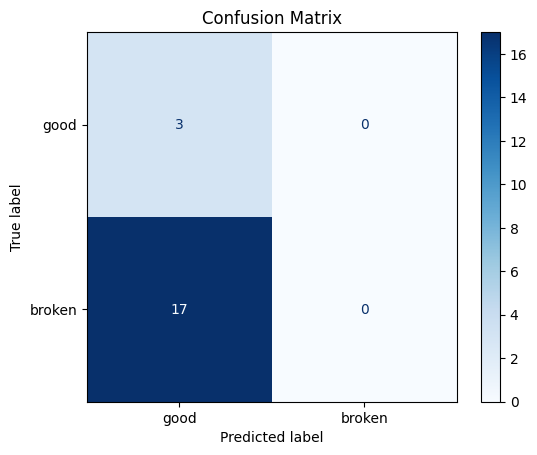

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# === Validation Setup ===
validate_folder = os.path.join(base_path, "..\\test")
class_names = ['good', 'broken']

# === Track Data ===
all_true_labels = []
all_predicted_labels = []
inference_times = []
all_filenames = []
umap_embeddings = []
umap_labels = []

# === Step 1: Run Inference ===
for label in class_names:
    label_folder = os.path.join(validate_folder, label)
    for filename in os.listdir(label_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(label_folder, filename)

            start_time = time.time()
            predicted_label, embedding = render_prediction(
                image_path,
                image_embeddings,
                processor,
                model,
                actual_label=label
            )
            elapsed_time = time.time() - start_time

            all_true_labels.append(label)
            all_predicted_labels.append(predicted_label)
            inference_times.append(elapsed_time)
            all_filenames.append(filename)

            if embedding is not None:
                umap_embeddings.append(embedding)
                umap_labels.append(label)

# === Step 2: Print Results ===


# === Step 3: Summary Metrics ===
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
avg_time = np.mean(inference_times)

print(f"\n🧠 Model Source: {getattr(model, 'name_or_path', 'Custom/Unknown (possibly fine-tuned)')}")
print(f"\n✅ Validation Accuracy: {accuracy:.2%}")
print(f"⚡ Avg Inference Time per Image: {avg_time:.4f} seconds")

# === Step 4: Confusion Matrix ===
cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# === Step 5: Combine & Plot UMAP ===Doesn't work as intended
#combined_embeddings = individual_embeddings + umap_embeddings
#combined_labels = individual_labels + umap_labels

#plot_umap(combined_embeddings, combined_labels)


#Fine tuning

##Prework

In [96]:
# === Custom PyTorch Dataset for Circuit Board Images ===

from torch.utils.data import Dataset

class CircuitBoardDataset(Dataset):
    def __init__(self, reference_image_paths, processor):
        """
        Initializes the dataset by loading image paths and assigning labels.

        Args:
            reference_image_paths (dict): A dictionary with class names ("Healthy", "Faulty")
                                          as keys and lists of image paths as values.
            processor (CLIPProcessor): The processor to convert images to tensors.
        """
        self.processor = processor
        self.images = []  # Stores image file paths
        self.labels = []  # Stores numeric labels (0 for Healthy, 1 for Faulty)

        # Map textual class labels to integer values for use in training
        label_map = {"good": 0, "broken": 1}

        # Loop through each class and its associated image paths
        for label_name, img_list in reference_image_paths.items():
            label = label_map[label_name]  # Convert label name to numeric ID

            for img_path in img_list:
                # Check that the file actually exists (optional safety check)
                if os.path.isfile(img_path):
                    self.images.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        """
        Returns:
            Total number of samples in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieves one sample (image tensor and label) by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A tuple of:
                - pixel_values (Tensor): Image tensor processed for CLIP.
                - label (int): Class label (0 or 1).
        """
        # Load and preprocess the image
        img = Image.open(self.images[idx]).convert("RGB")

        # Use the CLIP processor to transform the image into a model-ready tensor
        inputs = self.processor(images=img, return_tensors="pt")

        # Retrieve the label for this image
        label = self.labels[idx]

        # Return the image tensor (remove batch dim) and label
        return inputs['pixel_values'].squeeze(0), label


In [97]:
# === Initialize the Custom Dataset ===

from collections import Counter


# Create an instance of the CircuitBoardDataset with your image paths and CLIP processor.
# This will allow PyTorch to fetch image-label pairs on demand.
dataset = CircuitBoardDataset(reference_image_paths, processor)
print(f"Total samples: {len(dataset)}")
print("Label distribution:", Counter(dataset.labels))

# === Wrap the Dataset in a DataLoader ===

# The DataLoader handles batching and shuffling of data for training.
# - batch_size=16: Processes 16 images per training step.
# - shuffle=True: Randomly shuffles the dataset each epoch for better generalization.
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


# === Set the Device (GPU if available, else CPU) ===

# This determines where your model and tensors should live (for performance).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Total samples: 15
Label distribution: Counter({0: 15})


In [98]:
from torch.nn import CosineEmbeddingLoss
from tqdm import tqdm
import torch.optim as optim
import torch

# === Configurable Hyperparameters ===
margin = 1.5
learning_rate = 1e-7
epochs = 20
unfreeze_last_block = True

# === Fault Checks: Ensure model & loader exist ===
assert model is not None, "❌ Model is not defined."
assert train_loader is not None, "❌ train_loader is not defined."
assert hasattr(model, "get_image_features"), "❌ model must have get_image_features() method."

# === Freeze All Parameters Initially ===
for param in model.parameters():
    param.requires_grad = False

# === Unfreeze Visual Projection Head ===
if hasattr(model, "visual_projection"):
    for param in model.visual_projection.parameters():
        param.requires_grad = True
else:
    raise AttributeError("❌ model.visual_projection not found.")

# === Optionally Unfreeze Last Transformer Block ===
if unfreeze_last_block:
    try:
        for param in model.vision_model.encoder.layers[-1].parameters():
            param.requires_grad = True
        print("🔓 Unfroze last transformer block.")
    except AttributeError:
        print("⚠️ model.vision_model.encoder.layers[-1] not found. Skipping.")

# === Log Trainable Parameters ===
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"🔧 Trainable parameters: {trainable:,} / {total:,} ({(trainable/total)*100:.2f}%)")

# === Set Up Loss and Optimizer ===
loss_fn = CosineEmbeddingLoss(margin=margin)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# === Training Loop ===
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    skipped_batches = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        if images.size(0) < 2:
            print("⚠️ Skipping batch with fewer than 2 images.")
            skipped_batches += 1
            continue

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        try:
            embeddings = model.get_image_features(pixel_values=images)
        except Exception as e:
            print(f"❌ Error generating embeddings: {e}")
            skipped_batches += 1
            continue

        embedding_pairs = []
        target_labels = []

        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):
                embedding_pairs.append((embeddings[i], embeddings[j]))
                target = 1 if labels[i].item() == labels[j].item() else -1
                target_labels.append(target)

        if not embedding_pairs:
            print("⚠️ No valid image pairs in batch — skipping.")
            skipped_batches += 1
            continue

        emb1 = torch.stack([p[0] for p in embedding_pairs])
        emb2 = torch.stack([p[1] for p in embedding_pairs])
        targets = torch.tensor(target_labels, device=device, dtype=torch.float)

        loss = loss_fn(emb1, emb2, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"📉 Epoch {epoch+1}: Loss = {epoch_loss:.4f} | Skipped batches: {skipped_batches}")

# === Save Model ===
model.name_or_path = "fine-tuned-clip-last-layer-only"
torch.save(model.state_dict(), "fine_tuned_clip_last_layer.pt")
print("💾 Saved model: fine_tuned_clip_last_layer.pt")


🔓 Unfroze last transformer block.
🔧 Trainable parameters: 7,481,088 / 151,277,313 (4.95%)


Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


📉 Epoch 1: Loss = 0.0265 | Skipped batches: 0


Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


📉 Epoch 2: Loss = 0.0264 | Skipped batches: 0


Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


📉 Epoch 3: Loss = 0.0264 | Skipped batches: 0


Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


📉 Epoch 4: Loss = 0.0263 | Skipped batches: 0


Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


📉 Epoch 5: Loss = 0.0263 | Skipped batches: 0


Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


📉 Epoch 6: Loss = 0.0262 | Skipped batches: 0


Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


📉 Epoch 7: Loss = 0.0262 | Skipped batches: 0


Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


📉 Epoch 8: Loss = 0.0262 | Skipped batches: 0


Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


📉 Epoch 9: Loss = 0.0261 | Skipped batches: 0


Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


📉 Epoch 10: Loss = 0.0261 | Skipped batches: 0


Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


📉 Epoch 11: Loss = 0.0260 | Skipped batches: 0


Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


📉 Epoch 12: Loss = 0.0260 | Skipped batches: 0


Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


📉 Epoch 13: Loss = 0.0259 | Skipped batches: 0


Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


📉 Epoch 14: Loss = 0.0259 | Skipped batches: 0


Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


📉 Epoch 15: Loss = 0.0258 | Skipped batches: 0


Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


📉 Epoch 16: Loss = 0.0258 | Skipped batches: 0


Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


📉 Epoch 17: Loss = 0.0257 | Skipped batches: 0


Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


📉 Epoch 18: Loss = 0.0257 | Skipped batches: 0


Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


📉 Epoch 19: Loss = 0.0257 | Skipped batches: 0


Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


📉 Epoch 20: Loss = 0.0256 | Skipped batches: 0
💾 Saved model: fine_tuned_clip_last_layer.pt


In [99]:
print("🔎 Model Debug Info")
print(f"• Architecture: {type(model).__name__}")
print(f"• Source: {getattr(model, 'name_or_path', 'unknown')}")
print(f"• Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"• Model fingerprint: {fingerprint_model(model)}")

🔎 Model Debug Info
• Architecture: CLIPModel
• Source: fine-tuned-clip-last-layer-only
• Trainable params: 7481088
• Model fingerprint: 3db3c898c7


In [100]:
from transformers import CLIPModel

model_f = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")  # or your base
model_f.load_state_dict(torch.load("fine_tuned_clip_last_layer.pt"))
model_f.to(device)
model_f.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [101]:
print("🔎 Model Debug Info")
print(f"• Architecture: {type(model_f).__name__}")
print(f"• Source: {getattr(model_f, 'name_or_path', 'unknown')}")
print(f"• Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"• Model fingerprint: {fingerprint_model(model_f)}")

🔎 Model Debug Info
• Architecture: CLIPModel
• Source: openai/clip-vit-base-patch32
• Trainable params: 7481088
• Model fingerprint: 3db3c898c7


In [105]:
# === Recompute Embeddings After Fine-Tuning ===

# After updating the CLIP model's weights (via contrastive learning),
# we need to regenerate embeddings to reflect those changes.

image_embeddings_f, individual_embeddings_f, individual_labels_f = generate_image_embeddings(
    reference_image_paths, processor, model_f
)

# image_embeddings: dict → class name → average embedding
# individual_embeddings: list → one 512-dim vector per image
# individual_labels: list of class labels
# individual_paths: list of file paths (used for visualization/debugging)


📷 Image: 20250422_200412.jpg
✅ Actual:    good
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9885 (Threshold: 0.93)

📷 Image: 20250422_200413.jpg
✅ Actual:    good
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9903 (Threshold: 0.93)

📷 Image: 20250422_200415.jpg
✅ Actual:    good
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9856 (Threshold: 0.93)

📷 Image: 20250422_200351.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9684 (Threshold: 0.93)

📷 Image: 20250422_200354.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9901 (Threshold: 0.93)

📷 Image: 20250422_200356.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9879 (Threshold: 0.93)

📷 Image: 20250422_200357.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9882 (Threshold: 0.93)

📷 Image: 20250422_200358.jpg
✅ Actual:    broken
🔮 Predicted: good
🔍 Cosine Similarity to 'good': 0.9776 (Threshold: 0.93)

📷 Image: 2025

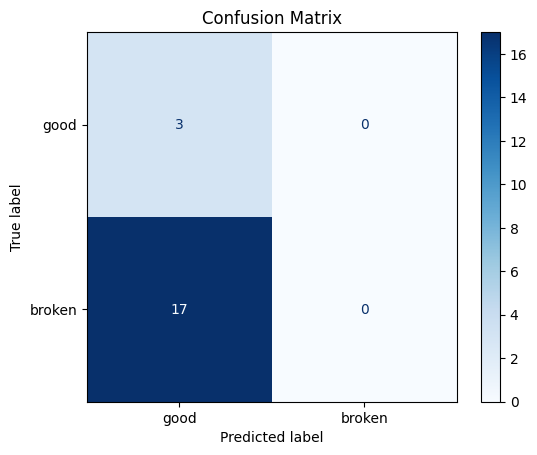

In [104]:
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# === Validation Setup ===
validate_folder = os.path.join(base_path, "..\\test")
class_names = ['good', 'broken']

# === Track Data ===
all_true_labels = []
all_predicted_labels = []
inference_times = []
all_filenames = []
umap_embeddings = []
umap_labels = []

# === Step 1: Run Inference ===
for label in class_names:
    label_folder = os.path.join(validate_folder, label)
    for filename in os.listdir(label_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(label_folder, filename)

            start_time = time.time()
            predicted_label_f, embedding_f = render_prediction(
                image_path,
                image_embeddings_f,
                processor,
                model_f,
                actual_label=label
            )
            elapsed_time = time.time() - start_time

            all_true_labels.append(label)
            all_predicted_labels.append(predicted_label_f)
            inference_times.append(elapsed_time)
            all_filenames.append(filename)

            if embedding_f is not None:
                umap_embeddings.append(embedding_f)
                umap_labels.append(label)

# === Step 2: Print Results ===


# === Step 3: Summary Metrics ===
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
avg_time = np.mean(inference_times)

print(f"\n🧠 Model Source: {getattr(model_f, 'name_or_path', 'Custom/Unknown (possibly fine-tuned)')}")
print(f"\n✅ Validation Accuracy: {accuracy:.2%}")
print(f"⚡ Avg Inference Time per Image: {avg_time:.4f} seconds")

# === Step 4: Confusion Matrix ===
cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# === Step 5: Combine & Plot UMAP === Doesn't work as intended
#combined_embeddings = individual_embeddings_f + umap_embeddings
#combined_labels = individual_labels_f + umap_labels

#plot_umap(combined_embeddings, combined_labels)
